<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/Data_Visualization/explore_sentinel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Setup

Install essential packages missing from the Google Colab environment and import all required packages for the functions in this notebook.

In [1]:
%%capture
!pip -q install geojson
!pip -q install rasterio
!pip -q install eeconvert
!pip -q install geemap
!pip install ffmpeg-python

In [2]:
# Standard imports
import os
import json
import time
import datetime
import imageio
import re

# Geospatial processing packages
import geopandas as gpd
import geojson
import shapely
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import reshape_as_image
import rasterio.mask
from shapely.geometry import Point, Polygon, box
from pyproj import Transformer

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.foliumap as emap
import folium
import numpy as np

### Mount Google Drive and install project files from GitHub

First, we'll mount our Google Drive as we'll save the GeoTiff files to our drive. Then we'll clone the main branch from the GitHub repo so we have access to all of the files from there. In particular, we need access to the shape files for the training and test sets.

In [3]:
# mount your drive in case you have any new data uploaded there you want to use
from google.colab import drive
drive.mount('/content/drive')

# clone the main branch from GitHub to get all the data and files from there onto the current runtime session
!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git
!git pull # pulls the latest changes from repo

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'zindi-amazon-secret-runway'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 359 (delta 89), reused 99 (delta 42), pack-reused 162 (from 1)
Receiving objects: 100% (359/359), 56.98 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (156/156), done.
fatal: not a git repository (or any of the parent directories): .git


### Authenticate Google Earth Engine
Make sure you have signed up for access to Google Earth Engine. You will need to edit the following code cell to use your own account. All the Sentinel data will be downloaded through the Google Earth Engine.

In [4]:
ee.Authenticate()
ee.Initialize(project="ee-fortinpascal")

### Setup the main paths to the project files and the download location on your Google Drive

You should edit the name of the export folder and select your prefered folder on your Google Drive.

In [5]:
airstrip_training_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/pac_2024_training/pac_2024_training.shp'
base_aoi_path = '/content/zindi-amazon-secret-runway/Data_Visualization/data/shp_test_AOIs'

# Select export folder on Google Drive
export_folder = 'Colab Notebooks'

### Functions to download and manipulate Sentinel data

A significant amount of time was spent downloading and visualizing the Sentinel 1 and 2 data. Many of those functions are useful for exploring different aspects of the data. From interactive maps using the Folium package, to animated GIFs and multi-band images display.

In [6]:
def create_square_pentagon(center_lon, center_lat, side_length_meters):
  """
  Creates a square geopandas pentagon centered on
  a set of Lon/Lat coordinates.

  Args:
    center_lon: The longitude of the center point.
    center_lat: The latitude of the center point.
    side_length_meters: The length of each side of
                         the square in meters.

  Returns:
    A geopandas GeoDataFrame containing the pentagon.
  """

  # Define the source and destination coordinate systems
  source_crs = "EPSG:4326"  # WGS 84 (Lon/Lat)
  target_crs = "EPSG:3395"  # World Mercator (meters)


  # Create a transformer object to convert between coordinate systems
  transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

  # Transform the center coordinates to Web Mercator
  center_x, center_y = transformer.transform(center_lon, center_lat)

  # Calculate half the side length
  half_side = side_length_meters / 2

  coordinates = [
      (center_x - half_side, center_y + half_side),  # Top left
      (center_x + half_side, center_y + half_side),  # Top right
      (center_x + half_side, center_y - half_side),  # Bottom right
      (center_x - half_side, center_y - half_side),  # Bottom Left
      (center_x - half_side, center_y + half_side)   # Top left (close the polygon)
  ]


  # Create a Polygon object from the coordinates
  polygon = Polygon(coordinates)

  # Create a GeoDataFrame from the Polygon with World Mercator CRS
  gdf = gpd.GeoDataFrame(geometry=[polygon], crs=target_crs)

  # Transform the GeoDataFrame back to WGS 84
  gdf = gdf.to_crs(source_crs)

  return gdf

In [31]:
def create_square_around_point(center: Point, side_length: float) -> Polygon:
    """
    Create a square polygon centered on a shapely Point object.

    Args:
        center (Point): The shapely Point object representing the center.
        side_length (float): The length of the sides of the square.

    Returns:
        Polygon: A shapely Polygon object representing the square.
    """
    # Half the side length for corner calculations
    half_side = side_length / 2

    # Get the center point coordinates
    x_center, y_center = center.x, center.y

    # Create the corners of the square
    square_coords = [
        (x_center - half_side, y_center - half_side),  # Bottom-left corner
        (x_center + half_side, y_center - half_side),  # Bottom-right corner
        (x_center + half_side, y_center + half_side),  # Top-right corner
        (x_center - half_side, y_center + half_side),  # Top-left corner
        (x_center - half_side, y_center - half_side)   # Closing the square
    ]

    # Create the polygon using the coordinates
    square_polygon = Polygon(square_coords)

    return square_polygon


In [35]:
def export_image(image,region,filename_prefix,bands,export_folder,scale=10,crs=None,crsTransform=None):
  """
  Function to export an image as GeoTIFF and save it to Google Drive

  Args:
    image:            Google Earth Engine image
    region:           Geometry to clip the image to
    filename_prefix:  Prefix for the filename
    bands:            List of bands to export
    export_folder:    Google Drive folder to save to
    scale:            Pixel scale (in meters) for the output image
    crs:              CRS to export to (default: EPSG:4326)
    crsTransform:     Affine transformation matrix for the output image

  Returns:
    None

  """


  # Check if the image has the 'system:time_start' property.
  if 'system:time_start' in image.propertyNames().getInfo():
      date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
      filename = f"{filename_prefix}_{date}"
  else:
      # Handle the case where the property is missing (e.g., use a default date)
      #date = 'no_date'
      #filename = f"{filename_prefix}_{date}"
      filename = f'{filename_prefix}' # No date at all...

  task = ee.batch.Export.image.toDrive(
        image=image.select(bands).clip(region),
        description='filename',
        folder=export_folder,
        fileNamePrefix=filename,
        scale=scale,
        crs=crs,
        crsTransform=crsTransform,
        region=region.getInfo()['coordinates'],
        maxPixels=1e13,
        fileFormat='GeoTIFF'
  )
  task.start()
  print(f'Task ID: {task.id}')
  print('Exporting to Google Drive...')


In [8]:
def check_all_tasks_completed():
  """Checks if all Earth Engine tasks have completed.

  Returns:
    bool: True if all tasks have completed, False otherwise.
  """

  tasks = ee.batch.Task.list()
  for task in tasks:
    if task.status()['state'] != 'COMPLETED':
      return False
  return True

In [9]:
# Helper function to calculate VV/VH ratio and add it as a new band
def add_vv_vh_ratio(image):
    ratio_band = image.select('VV').divide(image.select('VH')).rename('VV_VH_Ratio')
    return image.addBands(ratio_band)


In [10]:
def download_s1_images(
    region,
    bands = ['VV', 'VH'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    product='COPERNICUS/S1_GRD',
    min_date='2024-04-01',
    max_date='2024-06-01',
):

    """Generates Sentinel-1 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      filename_prefix: Filename prexix to save to disk
      export_folder: Google Drive folder to save to
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-1 images clipped to the region of interest
    """

    # Define the Sentinel-1 image collection and filter by date and region.
    sentinel1 = ee.ImageCollection(product) \
        .filterDate(min_date, max_date) \
        .filterBounds(region) \
        .filter(ee.Filter.eq('instrumentMode', 'IW'))  # Interferometric Wide (IW) swath mode

    # Apply the export function to each image in the collection.
    collection_list = sentinel1.toList(sentinel1.size())
    for i in range(sentinel1.size().getInfo()):
      image = ee.Image(collection_list.get(i))
      export_image(image=image,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)

    print("Export tasks should be complete.")


In [11]:
def download_s2_images(
    region,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    product='COPERNICUS/S2_SR_HARMONIZED',
    min_date='2023-01-01',
    max_date='2024-06-01',
    cloud_pct=10
):

    """Generates cloud-filtered, Sentinel-2 images from
    Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 images clipped to the region of interest
    """

    # Generate collection of images
    sentinel2 = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))

    # Apply the export function to each image in the collection.
    collection_list = sentinel2.toList(sentinel2.size())
    for i in range(sentinel2.size().getInfo()):
      image = ee.Image(collection_list.get(i))
      export_image(image=image,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)

    print("Export tasks should be complete.")


In [12]:
def download_s2_cloud_score_composite_image(
    region,
    scale=10,
    crs=None,
    crsTransform=None,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    filename_prefix='Sentinel2',
    export_folder='Colab Notebooks',
    s2_product='COPERNICUS/S2_SR_HARMONIZED',
    csPlus_product='GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED',
    min_date='2023-01-01',
    max_date='2024-06-01',
    QA_BAND='cs_cdf',
    clr_thres=0.60
):

    """Generates cloud-filtered, Sentinel-2 images from
    Google Earth Engine using the Python Earth Engine API.
    Downloads resulting composite image to Google Drive.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      scale: Pixel scale (in meters) for the output image.
      crs: Coordinate reference system (CRS) for the output image.
      crsTransform: Affine transformation matrix for the output image.
      bands: List of bands to export.
      filename_prefix: Filename prexix to save to disk
      export_folder: Google Drive folder to save to
      s2_product (str): Earth Engine asset ID
      csPlus_product (str): Earth Engine asset ID for the Cloud Score Plus product
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      QA_BAND (str): Use 'cs' or 'cs_cdf', depending on your use case;
        see docs for guidance.
      clr_thres (float): The threshold for masking; values between 0.50 and
        0.65 generally work well. Higher values will remove thin clouds,
        haze & cirrus shadows.
    """

    # Convert region of interest CRS to 4326 (needed by Google Earth Engine)
    region_4326 = region.transform(ee.Projection('EPSG:4326'), maxError=0.001)


    # Generate collection of images
    sentinel2 = ee.ImageCollection(s2_product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))

    # Import the Cloud Score Plus collection
    cs = ee.ImageCollection(csPlus_product)

    # Link the Sentinel-2 and Cloud Score Plus collections
    linked_collection = sentinel2.linkCollection(cs, [QA_BAND])

    # Define a function to mask clouds based on the Cloud Score Plus score
    def cloudMask(image):
        qa = image.select(QA_BAND)
        mask = qa.gte(clr_thres)
        return image.updateMask(mask)

    # Apply the cloud mask function to the linked collection
    masked_collection = linked_collection.map(cloudMask)

    # Create a median composite image
    median_composite = masked_collection.median()

    # Apply the export function.
    image = ee.Image(median_composite)
    export_image(image=image,region=region_4326,scale=scale,crs=crs,crsTransform=crsTransform,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)
    print("Export tasks should be complete.")



In [13]:
def download_s1_and_s2_cloud_score_composite_image(
    region,
    scale=10,
    crs=None,
    crsTransform=None,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'VV', 'VH', 'VV_VH_Ratio'],
    filename_prefix='Sentinel',
    export_folder='Colab Notebooks',
    s1_product='COPERNICUS/S1_GRD',
    s2_product='COPERNICUS/S2_SR_HARMONIZED',
    csPlus_product='GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED',
    min_date='2023-01-01',
    max_date='2024-06-01',
    QA_BAND='cs_cdf',
    clr_thres=0.60
):

    """Generates cloud-filtered, Sentinel-2 images from Google Earth Engine
    using the Python Earth Engine API. Generate and merge Sentinel 1 images.
    Downloads resulting composite image to Google Drive.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      scale: Pixel scale (in meters) for the output image.
      crs: Coordinate reference system (CRS) for the output image.
      crsTransform: Affine transformation matrix for the output image.
      bands: List of bands to export.
      filename_prefix: Filename prexix to save to disk
      export_folder: Google Drive folder to save to
      s1_product (str): Earth Engine asset ID for Sentinel-1
      s2_product (str): Earth Engine asset ID for Sentinel-2
      csPlus_product (str): Earth Engine asset ID for the Cloud Score Plus product
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      QA_BAND (str): Use 'cs' or 'cs_cdf', depending on your use case;
        see docs for guidance.
      clr_thres (float): The threshold for masking; values between 0.50 and
        0.65 generally work well. Higher values will remove thin clouds,
        haze & cirrus shadows.
    """

    # Convert region of interest CRS to 4326 (needed by Google Earth Engine)
    region_4326 = region.transform(ee.Projection('EPSG:4326'), maxError=0.001)

    # Define the Sentinel-2 image collection and filter by date and region.
    sentinel2 = ee.ImageCollection(s2_product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))

    # Import the Cloud Score Plus collection
    cs = ee.ImageCollection(csPlus_product)

    # Link the Sentinel-2 and Cloud Score Plus collections
    s2_linked_collection = sentinel2.linkCollection(cs, [QA_BAND])

    # Define a function to mask clouds based on the Cloud Score Plus score
    def cloudMask(image):
        qa = image.select(QA_BAND)
        mask = qa.gte(clr_thres)
        return image.updateMask(mask)

    # Apply the cloud mask function to the linked collection
    s2_masked_collection = s2_linked_collection.map(cloudMask)

    # Create a S2 median composite image
    s2_median_composite = s2_masked_collection.median()

    # Define the Sentinel-1 image collection and filter by date and region.
    sentinel1 = ee.ImageCollection(s1_product) \
        .filterDate(min_date, max_date) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .map(lambda img: add_vv_vh_ratio(img))

    # Create a S1 median composite image
    s1_median_composite = sentinel1.median()

    # Combine S1 and S2 collections into one image
    combined_image = s2_median_composite.addBands(s1_median_composite);

    # Apply the export function.
    image = ee.Image(combined_image)
    export_image(image=image,region=region_4326,scale=scale,crs=crs,crsTransform=crsTransform,filename_prefix=filename_prefix,bands=bands,export_folder=export_folder)
    print("Export tasks should be complete.")




In [14]:
def plot_s1_images(
    region,
    bands = ['VV', 'VH'],
    product='COPERNICUS/S1_GRD',
    min_date='2024-06-01',
    max_date='2024-07-01'
):

    """Generates Sentinel-1 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images

    Returns:
      Map
    """

    # Define the Sentinel-1 image collection and filter by date and region.
    sentinel1 = ee.ImageCollection(product) \
        .filterDate(min_date, max_date) \
        .filterBounds(region) \
        .filter(ee.Filter.eq('instrumentMode', 'IW'))  # Interferometric Wide (IW) swath mode

    # Get the most recent image in the collection.
    most_recent_image = sentinel1.sort('system:time_start', False).first().clip(region)

    # Select the VV and VH bands.
    vv_vh_image = most_recent_image.select(['VV', 'VH'])

    # Create a map.
    location = region.centroid().coordinates().getInfo()[::-1]
    Map = geemap.Map(center=location, zoom=10, basemap='SATELLITE')

    # Add Google TERRAIN as a base map.
    Map.add_basemap('TERRAIN')

    # Define visualization parameters for the VV and VH bands.
    #vv_vis_params = {
    #    'min': -25,
    #    'max': 0,
    #    'palette': ['blue', 'white', 'green']
    #}
    vv_vis_params = {
        'min': -25,
        'max': 0,
        'palette': ['black', 'white']
    }


    vh_vis_params = {
        'min': -25,
        'max': 0,
        'palette': ['purple', 'white', 'orange']
    }

    # Make an RGB color composite image (VV,VH,VV/VH).
    rgb = ee.Image.rgb(vv_vh_image.select('VV'),
                       vv_vh_image.select('VH'),
                       vv_vh_image.select('VV').divide(vv_vh_image.select('VH')))


    # Add the S1 rgb composite to the map object.
    Map.addLayer(rgb, {'min': [-25, -25, 0], 'max': [0, 0, 2]}, 'Fake S1 RGB')

    # Add the VV band layer to the map.
    Map.addLayer(vv_vh_image.select('VV'), vv_vis_params, 'VV Band')

    # Add the VH band layer to the map.
    Map.addLayer(vv_vh_image.select('VH'), vh_vis_params, 'VH Band')

    # Add the region of interest as a layer.
    Map.addLayer(region, {}, 'Region of Interest')

    # Display the map.
    Map.addLayerControl()  # This line will add a layer control to toggle the layers on/off.
    return Map


In [15]:
def plot_s2_images(
    region,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    product='COPERNICUS/S2_SR_HARMONIZED',
    min_date='2024-06-01',
    max_date='2024-07-01',
    cloud_pct=10
):

    """Generates Sentinel-2 images from Google Earth Engine using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      bands: List of bands
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images

    Returns:
      Map
    """

    # Define the Sentinel-2 image collection and filter by date and region.
    # Generate collection of images
    sentinel2 = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))

    # Get the most recent image in the collection.
    most_recent_image = sentinel2.sort('system:time_start', False).first().clip(region)

    # Select the bands to plot.
    s2_image = most_recent_image.select(bands)

    # Select all bands
    band_names = s2_image.bandNames().getInfo()

    # Create an RGB visualization layer (bands 4, 3, 2 correspond to Red, Green, Blue)
    rgb_viz_params = {
        'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
        'min': 0,
        'max': 3000,
        'gamma': [0.95, 1.1, 1]
    }

    # Create a map.
    location = region.centroid().coordinates().getInfo()[::-1]
    Map = geemap.Map(center=location, zoom=10, basemap='SATELLITE')

    # Add Google TERRAIN as a base map.
    Map.add_basemap('TERRAIN')

    # Add all individual bands as layers
    for band in band_names:
        Map.addLayer(s2_image.select(band), {'min': 0, 'max': 3000}, f'Sentinel-2 {band}')

    # Add the RGB visualization layer
    Map.addLayer(s2_image, rgb_viz_params, 'Sentinel-2 RGB')

    # Add the region of interest as a layer.
    Map.addLayer(region, {}, 'Region of Interest')

    # Display the map.
    Map.addLayerControl()  # This line will add a layer control to toggle the layers on/off.
    return Map


In [16]:
def plot_s2_cloudless_images(
    region,
    airstrip_gdf,
    bands=['B4', 'B3', 'B2', 'B8', 'B11', 'B12'],
    product='COPERNICUS/S2_HARMONIZED',
    csPlus_product='GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED',
    min_date='2020-01-01',
    max_date='2021-12-31',
    QA_BAND='cs_cdf',
    clr_thres=0.60
):

    """Generates Sentinel-2 images from GEE using the Python API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to
      airstrip_gdf: GeoDataFrame containing the airstrips
      bands: List of bands
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      cdPlus_prodict: Not really an option..
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      QA_BAND (str): Use 'cs' or 'cs_cdf', depending on your use case;
        see docs for guidance.
      clr_thres (float): The threshold for masking; values between 0.50 and
        0.65 generally work well.

    Returns:
      Map
    """

    # Generate collection of images
    sentinel2 = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))

    # Import the Cloud Score Plus collection
    cs = ee.ImageCollection(csPlus_product)

    # Link the Sentinel-2 and Cloud Score Plus collections
    linked_collection = sentinel2.linkCollection(cs, [QA_BAND])

    # Define a function to mask clouds based on the Cloud Score Plus score
    def cloudMask(image):
        qa = image.select(QA_BAND)
        mask = qa.gte(clr_thres)
        return image.updateMask(mask)

    # Apply the cloud mask function to the linked collection
    masked_collection = linked_collection.map(cloudMask)

    # Create a median composite image
    median_composite = masked_collection.median().clip(region)

    # Select the bands
    s2_image = median_composite.select(bands)

    # Extract the band names
    band_names = s2_image.bandNames().getInfo()

    # Create an RGB visualization layer (bands 4, 3, 2 correspond to Red, Green, Blue)
    rgb_viz_params = {
        'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
        'min': 0,
        'max': 3000,
        'gamma': 1.9
    }

    # List to store the intersecting geometries
    intersecting_geometries = []

    # Loop through each geometry in the GeoPandas DataFrame
    for index, row in airstrip_gdf.iterrows():
        # Convert GeoPandas geometry to GeoJSON
        geom_geojson = row['geometry'].__geo_interface__

        # Convert GeoJSON to Earth Engine Geometry
        geom_ee = ee.Geometry(geom_geojson)

        # Check if the geometry intersects with the ee.Geometry object
        if geom_ee.intersects(region).getInfo():
            intersecting_geometries.append(geom_ee)


    # Create a map.
    location = region.centroid().coordinates().getInfo()[::-1]
    #Map = geemap.Map(center=location, zoom=12, basemap='SATELLITE')
    Map = geemap.Map(center=location, zoom=12)
    Map.add_basemap('SATELLITE')


    # Add all individual bands as layers
    #for band in band_names:
    #    Map.addLayer(s2_image.select(band), {'min': 0, 'max': 3000}, f'Sentinel-2 {band}')

    # Add the RGB visualization layer
    Map.addLayer(median_composite, rgb_viz_params, 'Sentinel-2 RGB')

    # Add the region of interest as a layer.
    #Map.addLayer(region, {'color': 'red', 'width': 1, 'fillColor': None}, 'Region of Interest')

    # Add the intersecting geometries to the map
    for index, geom in enumerate(intersecting_geometries):
        Map.addLayer(geom, {'color': 'blue'}, f'Intersecting Airstrip {index}')

    # Display the map.
    Map.addLayerControl()  # This line will add a layer control to toggle the layers on/off.
    return Map


In [17]:
def create_sentinel2_timelapse(region, start_date, end_date, output_video_path):
    # Load Sentinel-2 data and filter by date and region
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filterDate(start_date, end_date)\
                  .filterBounds(region)\
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

    count = collection.size()
    print('Number of images in the collection:',count.getInfo())


    # Define visualization parameters for the RGB composite
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
        'min': 0,
        'max': 3000,
        'gamma': 1.1
    }

    # Set timelapse parameters
    timelapse_params = {
        'bands': ['B4', 'B3', 'B2'],  # Use RGB bands
        'start_date': start_date,
        'end_date': end_date,
        'frequency': 'month',  # Time intervals
        'reducer': 'median',  # Use median exposure
        'date_format': 'YYYY-MM-dd',
        'dimensions': 720,
        'frames_per_second': 1,  # Adjust FPS for video
        'crs': 'EPSG:4326',
        'vis_params': vis_params
    }


    # Generate time-lapse and export to video
    timelapse = geemap.create_timelapse(
        collection=collection,
        region=region,
        out_gif=output_video_path,
        **timelapse_params
    )


In [18]:
def create_geotiff_timelapse(dir_path, output_gif):
    """
    Creates a timelapse animation from GeoTIFF files in a directory.

    Args:
        dir_path (str): Path to the directory containing GeoTIFF files.
        output_gif (str): Name of the output GIF file.
    """
    geotiff_files = [f for f in os.listdir(dir_path) if f.endswith('.tif')]
    geotiff_files.sort()  # Sort files to ensure correct order
    images = []
    for file in geotiff_files:
        file_path = os.path.join(dir_path, file)
        with rio.open(file_path) as src:
            image = src.read()
            num_bands = src.count
            bands = src.descriptions

            # Extract date from filename using regular expression
            match = re.search(r'(\d{4}-\d{2}-\d{2})', file)
            if match:
                date_str = match.group(1)
            else:
                date_str = 'Date not found'

            fig, axes = plt.subplots(1, num_bands, figsize=(30, 8))
            for i in range(num_bands):
                #show(image[i], ax=axes[i], cmap='gray', title=f'Band {i+1}')
                show(image[i], ax=axes[i], cmap='gray', title=bands[i])
            plt.suptitle(f'Date: {date_str}')  # Set date as figure title
            plt.tight_layout()
            temp_file = 'temp_plot.png'
            plt.savefig(temp_file)
            plt.close()
            images.append(imageio.imread(temp_file))
            os.remove(temp_file)
    imageio.mimsave(output_gif, images, fps=0.5)


In [19]:
def load_and_plot_geotiffs(directory, output_file, max_images=72, grid_size=(12, 6)):
    # List all GeoTIFF files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    files.sort()  # Sort files to ensure correct order
    files = files[:max_images]  # Limit to max_images

    if len(files) == 0:
        print("No GeoTIFF files found in the directory.")
        return

    # Set up the figure (no spaces between plots, no axes)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 2, grid_size[0] * 2))
    plt.subplots_adjust(wspace=0, hspace=0)

    # Loop through files and plot them
    for idx, file in enumerate(files):
        row, col = divmod(idx, grid_size[1])  # Calculate the row and column for the grid

        # Open the GeoTIFF file
        with rio.open(file) as src:
            # Read the RGB bands (B4, B3, B2). We need to find their indices
            # as they can be stored differently...
            bands = src.descriptions
            B4_idx = bands.index('B4') + 1
            B3_idx = bands.index('B3') + 1
            B2_idx = bands.index('B2') + 1
            b4 = src.read(B4_idx)  # Red
            b3 = src.read(B3_idx)  # Green
            b2 = src.read(B2_idx)  # Blue

            # Normalize the bands to range [0, 1] for plotting
            def normalize(band):
                return (band - band.min()) / (band.max() - band.min())

            rgb_image = np.dstack([normalize(b4), normalize(b3), normalize(b2)])

        # Plot the image in the grid
        ax = axes[row, col]
        ax.imshow(rgb_image)
        ax.axis('off')  # Disable axes
        # Overlay filename
        # Extract date from filename using regular expression
        match = re.search(r'(\d{4}-\d{2}-\d{2})', file)
        if match:
            date_str = match.group(1)
        else:
            date_str = 'Date not found'
        ax.text(0.5,
                   0.9,
                   date_str,
                   ha='center',
                   va='center',
                   transform=ax.transAxes,
                   color='white')


    # Remove remaining empty axes
    for idx in range(len(files), grid_size[0] * grid_size[1]):
        row, col = divmod(idx, grid_size[1])
        fig.delaxes(axes[row, col])

    # Save the result
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()


In [20]:
def latlon_to_utm_epsg(lat, lon):
    """
    Calculate the UTM EPSG code for a given latitude and longitude.

    Parameters:
        lat (float): Latitude in EPSG:4326 (degrees).
        lon (float): Longitude in EPSG:4326 (degrees).

    Returns:
        str: EPSG code for the corresponding UTM zone.
    """
    # Determine UTM zone number based on longitude
    utm_zone = int((lon + 180) // 6) + 1

    # Determine if the point is in the northern or southern hemisphere
    if lat >= 0:
        epsg_code = 32600 + utm_zone  # Northern hemisphere
    else:
        epsg_code = 32700 + utm_zone  # Southern hemisphere

    return f'EPSG:{epsg_code}'


## Sentinel data

For the training and test data sets, we use the shape files provided by the Zindi team.

Each training record contains columns for id, year of detection, largo (length in meters), Activo (activity status at the time of the competition), and geometry of type *LINESTRING* with coordinates (LNG LAT) which define points along the airstrip. For each airstrip, we'll define a square AOI to define a boundary when downloading Sentinel data.

For the test data set, the record contains the bounding box for each area. We use the bounding box to define the area requested from Google Earth Engine and make sure the Sentinel pixel grid is precisely aligned.

### Select the bands for both Sentinel 1 and 2

Not all bands may be used by the model, but it is better to have access to the bands in the GeoTIFF file should we decide to include more bands / channels at a later time.

In addition to the RGB bands (B4, B3, B2), we include the NIR, SWIR 1, and SWIR 2 bands. For the Sentinel 1 bands, we include bands VV and VH, and the ratio of those bands will be calculed before exporting the final GeoTIFF file.

In [21]:
s1_bands = ['VV', 'VH']
s2_bands = ['B4', 'B3', 'B2', 'B8', 'B11', 'B12']

### Read the shapefile for the training set and print information about the first few entries

In [22]:
# Read the shapefile for the training dataset
airstrip_training_gdf = gpd.read_file(airstrip_training_path)

# Display the data for information
print(airstrip_training_gdf.head(5).to_markdown(), "\n")
print(airstrip_training_gdf.info(), "\n")

|    |   id |   yr |    largo |   Activo | geometry                                                                                                                            |
|---:|-----:|-----:|---------:|---------:|:------------------------------------------------------------------------------------------------------------------------------------|
|  0 |    1 | 2023 |  968.918 |        0 | LINESTRING (-70.08928656863503 -13.129844039931504, -70.08052787039317 -13.128251134052485, -70.08052787039317 -13.128251134052485) |
|  1 |    2 | 2022 | 1105.49  |        0 | LINESTRING (-69.16744237255283 -13.620679758207931, -69.1728593987747 -13.612261251288524)                                          |
|  2 |    3 | 2015 |  985.018 |        0 | LINESTRING (-69.14224792429687 -13.694510447986984, -69.14189616934739 -13.685654549844925)                                         |
|  3 |    4 | 2020 |  681.914 |        0 | LINESTRING (-69.07843632939438 -13.787902019520923, -69.08404112675193 -

### Reproject the data to a projected CRS for accurate centroid calculation

In [23]:
# Temporarily reproject to a projected CRS for accurate centroid calculation
projected_airstrip_training_gdf = airstrip_training_gdf.to_crs(epsg=3395)  # World Mercator projection

## Download the training and test GeoTIFF files.


In [ ]:
# Get the current date and time
#now = datetime.datetime.now()
# Format the timestamp as YEAR-MONTH-DAY
#max_date = now.strftime("%Y-%m-%d")
#min_date = '2015-07-01' # Launch of Sentinel-2A

# This is the loop... We'll produce time lapses for all training entries
#for index, row in projected_airstrip_training_gdf.iterrows():
#    if index == 0:
        # Access the airstrip geometry and get the centroid.
#        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
#        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
#        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
#        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
#        region = tmp_AOI_fc.geometry()
#        video_file = f'sentinel2_idx_{index:03}_timelapse.gif'
        # Create the time-lapse video
#        create_sentinel2_timelapse(region, min_date, max_date, video_file)

Number of images in the collection: 22
Generating URL...
Please wait ...
The GIF image has been saved to: /content/drive/MyDrive/S2_AllBands_Idx_009/sentinel2_idx_000_timelapse.gif


In [ ]:
# DELETE THIS CELL BEFORE COMMITING CHANGES

# This cell is useful if you want to process a single entry in the training
# set. You can run on of the functions to download or plot data, etc...

#my_index = 9 # Change this number to get a different airstrip.
#centroid = projected_airstrip_training_gdf.geometry[my_index].centroid

# Convert the centroid back to WGS84 (LNG, LAT)
#centroid_wgs84 = gpd.GeoSeries([centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]

# Create a new AOI center on the centroid. The lenght of each side is 5km.
#newAOI = create_square_pentagon(centroid_wgs84.x, centroid_wgs84.y, 5000)

#newAOI_fc = geemap.geopandas_to_ee(newAOI)
#region = newAOI_fc.geometry()

# Make sure this folder already exists on your drive
#tmp_folder = f'S2_AllBands_Idx_{my_index:03}'
#tmp_file_prefix = f'S2_AllBands_Idx_{my_index:03}'

#download_s2_cloud_score_composite_image(region,\
#                                        bands=s2_bands,\
#                                        filename_prefix=tmp_file_prefix,\
#                                        export_folder=tmp_folder,\
#                                        min_date='2022-01-01',\
#                                        max_date='2023-01-01',\
#                                        QA_BAND='cs_cdf',\
#                                        clr_thres=0.60)



Task ID: TAF3XMGCTWCC2XMCFYNEA2BN
Exporting to Google Drive...
Export tasks should be complete.


In [ ]:
# Example usage
#directory = '/content/drive/MyDrive/S2_AllBands_Idx_009'
#output_file = 'geotiff_mosaic.png'
#load_and_plot_geotiffs(directory, output_file)


In [ ]:
# This cell is used to download all the S2 data for the training set and use the
# year of detection in the database as a starting point.
#
#   Steps:
#     - Create a working directory in your Google drive if it doesn't
#       already exist.
#     - Start loop over all training airstrips.
#        - Extract year of detection from database and create timestamps
#        - Download the Sentinel 2 images as GeoTIFF files
#        - Create composite image with up to 72 separate exposures
#        - Delete the .tif files and move to next entry.

#if not os.path.exists('/content/drive/MyDrive/Sentinel2_temp'):
#    os.makedirs('/content/drive/MyDrive/Sentinel2_temp')
#!cd /content/drive/MyDrive/Sentinel2_temp

#for index, row in projected_airstrip_training_gdf.iterrows():
#    if index == 1:
        # Access the airstrip geometry and get the centroid.
#        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
#        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
#        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
#        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
#       region = tmp_AOI_fc.geometry()

        # Get the year of detection and create timestamps for data extraction
#        tmp_year = row['yr']
#        tmp_min_date = f'{tmp_year}-01-01'
#        tmp_max_date = f'{tmp_year}-12-31'

        # Make sure this folder already exists on your drive
#        tmp_folder = "Sentinel2_temp"
#        tmp_file_prefix = f'S2_AllBands_Idx_{index:03}'


#        download_s2_images(region,\
#                           min_date=tmp_min_date,\
#                           max_date=tmp_max_date,\
#                           bands=s2_bands,\
#                           filename_prefix=tmp_file_prefix,\
#                           export_folder=tmp_folder,\
#                           cloud_pct=100)


#        while not check_all_tasks_completed():
#            print("Tasks still running. Waiting 60 seconds...")
#            time.sleep(60)
#        print("All tasks completed")

#        directory = '/content/drive/MyDrive/Sentinel2_temp'
#        output_file = f'{directory}/S2_RGB_time_series_{index:03}_{tmp_year}.png'
#       load_and_plot_geotiffs(directory, output_file)

        # Remove the tif files
#        !rm /content/drive/MyDrive/Sentinel2_temp/*.tif


Task ID: L73ZMGKVPZENYTVJCQ3KAFGE
Exporting to Google Drive...
Task ID: WFQA75EDK2O62ZDVV3L7WWW5
Exporting to Google Drive...
Task ID: O4TK4CTADB4SRT4FVK527SL6
Exporting to Google Drive...
Task ID: N7UF5UZKHEWTHEDJ3ZPYVVKR
Exporting to Google Drive...
Task ID: TUQ6HFVUCNKADCTTLUC3FOE5
Exporting to Google Drive...
Task ID: VKRYZZPHUCW2GFXY747U6L4F
Exporting to Google Drive...
Task ID: H75DTPGJJVYT3QGIESRMYCX3
Exporting to Google Drive...
Task ID: XHBRNPILOZTRQMXSRMUIP273
Exporting to Google Drive...
Task ID: ZGRHDOSGPWKLSZIZV65USRYD
Exporting to Google Drive...
Task ID: HGA77SG44JIWRFJ6PDEFTMYU
Exporting to Google Drive...
Task ID: CEUNM5X7KNOVS7DODZN66UZF
Exporting to Google Drive...
Task ID: ILCD6J4QMLF7LYPPJKZV63TX
Exporting to Google Drive...
Task ID: FFQNJST4M6PVK6JCLYC76YAB
Exporting to Google Drive...
Task ID: HZ5GMW5IEJIDGDSMUKAIEJ4E
Exporting to Google Drive...
Task ID: 6U6RVSAHJQ6ONBDY2DDLOHAJ
Exporting to Google Drive...
Task ID: PFDJVEFYFPBXRYISSCYNFR27
Exporting to Google D

In [ ]:
# This cell is used to create cloudless composite images using the  S2 data
# for the training set. We'll get images for all years starting in 2019
#
#   Steps:
#     - Create a working directory in your Google drive if it doesn't
#       already exist.
#     - Start loop over all training airstrips.

#if not os.path.exists('/content/drive/MyDrive/Sentinel2_temp'):
#    os.makedirs('/content/drive/MyDrive/Sentinel2_temp')
#!cd /content/drive/MyDrive/Sentinel2_temp

#for index, row in projected_airstrip_training_gdf.iterrows():
#    if index >= 60 and index <154:
        # Access the airstrip geometry and get the centroid.
#        tmp_centroid = row['geometry'].centroid
        # Convert the centroid back to WGS84 (LNG, LAT)
#        tmp_centroid_wgs84 = gpd.GeoSeries([tmp_centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
#        tmp_AOI = create_square_pentagon(tmp_centroid_wgs84.x, tmp_centroid_wgs84.y, 5000)
#        tmp_AOI_fc = geemap.geopandas_to_ee(tmp_AOI)
#        region = tmp_AOI_fc.geometry()

        # Make sure this folder already exists on your drive
#        tmp_folder = "Sentinel2_temp"

        # Loop over the entire data set.
#        for year in range(2015, 2025):
#            tmp_min_date = f'{year}-01-01'
#            tmp_max_date = f'{year}-12-31'
#            tmp_file_prefix = f'S2_AllBands_Idx_{index:03}_Year_{year}'

#            download_s2_cloud_score_composite_image(region,
#                                        bands=s2_bands,
#                                        filename_prefix=tmp_file_prefix,
#                                        s2_product='COPERNICUS/S2_HARMONIZED',
#                                        export_folder=tmp_folder,
#                                        min_date=tmp_min_date,
#                                        max_date=tmp_max_date,
#                                        QA_BAND='cs_cdf',
#                                        clr_thres=0.60)


Task ID: TOM6CJHFDJ6HXC2FS2XHPUXE
Exporting to Google Drive...
Export tasks should be complete.
Task ID: C7YFF7DFDPEN6M76HTTM4GFO
Exporting to Google Drive...
Export tasks should be complete.
Task ID: CBT6RSKKXGZE53NHN6OYAGON
Exporting to Google Drive...
Export tasks should be complete.
Task ID: 66B2PXY4ZPHFXTMNQLSSEMN7
Exporting to Google Drive...
Export tasks should be complete.
Task ID: XFEH4ISSVGHAFQWTDBMC3ODY
Exporting to Google Drive...
Export tasks should be complete.
Task ID: V6JLYCLSINSOSA2IZ352UBC5
Exporting to Google Drive...
Export tasks should be complete.
Task ID: GK4EIUJUJKSOGZYA563WKAVZ
Exporting to Google Drive...
Export tasks should be complete.
Task ID: JXZD3ZMWNDUNPLHGISHL3XTC
Exporting to Google Drive...
Export tasks should be complete.
Task ID: WDP6CZPNKCYBBPF7M5US37Q4
Exporting to Google Drive...
Export tasks should be complete.
Task ID: LJ34C2C2HABNC3YLL6MOK4OR
Exporting to Google Drive...
Export tasks should be complete.
Task ID: XGQQ7Y6VBXFQ2VRZJX7A3H3I
Export

In [ ]:
## DO NOT AUTOMATICALLY RUN THIS CELL !!!

# Path to directory with a series of GeoTIFF files
#geotiff_path = '/content/drive/MyDrive/Sentinel2_temp'
#%cd "$geotiff_path"

#for index, row in projected_airstrip_training_gdf.iterrows():
#    if index >= 150 and index <154:

#        pattern = f'Idx_{index:03}'
#        geotiff_files = []
#        images = []

#        for filename in os.listdir(geotiff_path):
#            if pattern in filename and filename.endswith('.tif'):
#                filepath = os.path.join(geotiff_path, filename)
#                geotiff_files.append(filepath)

#        geotiff_files.sort()  # Sort datasets to ensure correct order
#        for file in geotiff_files:
#            with rio.open(file) as src:
#               image = src.read()
#                num_bands = src.count
#                bands = src.descriptions
                # Extract year from filename using regular expression
#                match = re.search(r'(\d{4})', file)
#                if match:
#                    date_str = match.group(1)
#                else:
#                    date_str = 'Date not found'


#                fig, axes = plt.subplots(1, num_bands, figsize=(30, 8))
#                for i in range(num_bands):
#                    show(image[i], ax=axes[i], cmap='gray', title=bands[i])
#                plt.suptitle(f'Idx: {index:03} Date: {date_str}')  # Set date as figure title
#                plt.tight_layout()
#                temp_file = 'temp_plot.png'
#                plt.savefig(temp_file)
#                plt.close()
#                images.append(imageio.v2.imread(temp_file))
#                os.remove(temp_file)
#        output_gif = f'S2_AllBands_Idx_{index:03}_cloudless_timelapse.gif'
#        imageio.mimsave(output_gif, images, fps=0.5)


/content/drive/MyDrive/Sentinel2_temp


In [ ]:
#def plot_histograms(gdf, columns, bins=10, figsize=(10, 6)):
  """Plots histograms of selected columns in a GeoDataFrame.

  Args:
    gdf: The GeoDataFrame containing the data.
    columns: A list of column names to plot histograms for.
    bins: The number of bins to use for the histograms (default: 10).
    figsize: The size of the figure to create (default: (10, 6)).
  """

#  fig, axes = plt.subplots(len(columns), 1, figsize=figsize)  # Create subplots

#  for i, column in enumerate(columns):
#    ax = axes[i] if len(columns) > 1 else axes  # Handle single subplot case
#    gdf[column].hist(ax=ax, bins=bins)  # Plot histogram
    # Calculate and overlay mean and standard deviation
#    mean = gdf[column].mean()
#    std = gdf[column].std()
#    ax.axvline(mean, color='r', linestyle='--', label='Mean')
#    ax.axvline(mean + std, color='g', linestyle='-.', label='Std Dev')
#    ax.axvline(mean - std, color='g', linestyle='-.')


#    ax.set_title(f'Histogram of {column}')  # Set title
#    ax.set_xlabel(column)  # Set x-axis label
#    ax.set_ylabel('Frequency')  # Set y-axis label
#    ax.legend() # Add legend to display mean and std dev lines

#  plt.tight_layout()  # Adjust layout
#  plt.show()  # Display the plot

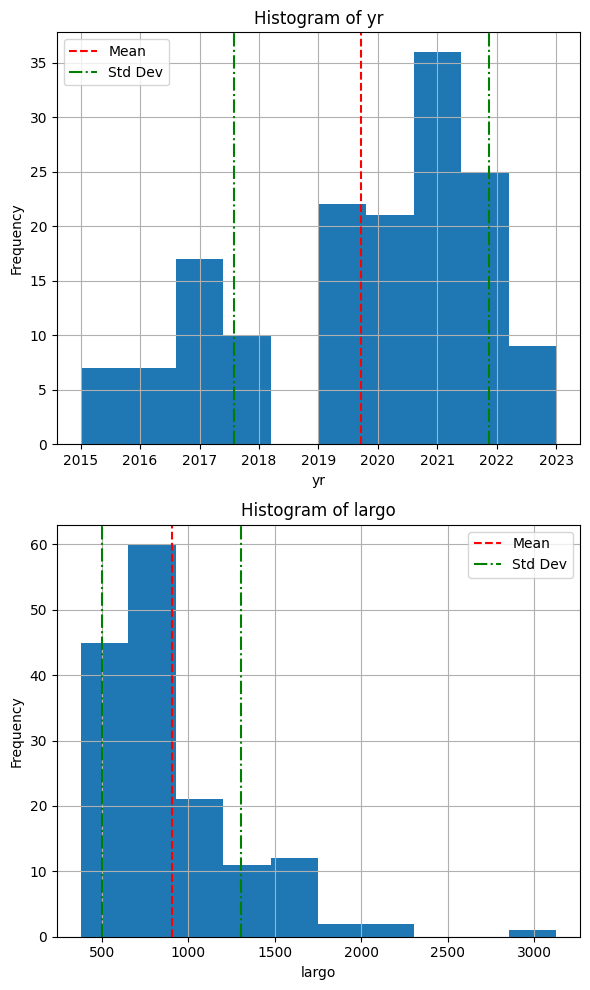

In [ ]:
#columns_to_plot = ['yr', 'largo']
#plot_histograms(projected_airstrip_training_gdf, columns_to_plot,figsize=(6,10))

In [ ]:
# Export database to CSV
#airstrip_training_gdf.drop(columns=['geometry']).to_csv('airstrip_training.csv', index=True)

### Download the testing GeoTIFF files

Those are the AOIs defined by the Zindi team for scoring. The GeoTIFF files will be used for inference with our model. Make sure to check the name of the output folder on your Google Drive before running the cell.

Step-by-step process for each AOI:


1.  Extract GeoJSON information (bounding box) stored inside the shape file.
2.  Create ee.Geometry object (region).
3.  Get the projection and CRS
4.  Get the coordinates of the bounding box and find the top left corner.
5.  Use the coordinates and scale parameter to create a CRS transfrom to precisely align the pixel scale with the bonding box.



In [30]:
# Edit the name of this folder to match the name of your prefered folder on your Google drive.
tmp_folder = "Sentinel_temp"

########################################################
#
# You shouldn't have to change anything below this line.
#
########################################################
aoi_files = ['aoi_2020_01', 'aoi_2020_02', 'aoi_2020_03', 'aoi_2021_01', 'aoi_2021_02', 'aoi_2021_03', 'aoi_2021_04', 'aoi_2022_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2024_01']

for aoi_file in aoi_files:
    airstrip_testing_gdf = gpd.read_file(f'{base_aoi_path}/{aoi_file}.shp')
    #print(airstrip_testing_gdf.head().to_markdown(), "\n")

    # Extract CRS of the AOI. We'll need this to export the final GeoTIFF image.
    aoi_crs = airstrip_testing_gdf.crs
    #print(f'Original CRS: {aoi_crs}',"\n")

    geojson_geometry = airstrip_testing_gdf.geometry[0].__geo_interface__
    region_utm = ee.Geometry(geojson_geometry,proj=f'{aoi_crs}',geodesic=False)
    polygon_crs = region_utm.projection()
    output_crs = polygon_crs.crs().getInfo()
    bounds_utm = region_utm.bounds(maxError=0.01,proj=polygon_crs)
    coords_utm = bounds_utm.coordinates().getInfo()[0]
    x_min = min([coord[0] for coord in coords_utm])
    y_max = max([coord[1] for coord in coords_utm])
    #print("Coordinates (UTM):",coords_utm)
    #print(f'Coordintates for top left corner: {x_min},{y_max}')

    # Set the scale (10m native Sentinel-2 resolution)
    export_scale = 10  # meters

    # Generate crsTransform to align pixels with the polygon bounding box
    # We'll use the top left corner of the polygon to define the transformation.
    # CRS Transform follows the form [scaleX, 0, translateX, 0, scaleY, translateY]
    # Units must be the same as the output CRS, i.e. UTM in our case.
    crs_transform = [export_scale, 0, x_min, 0, -export_scale, y_max]
    #print(crs_transform)

    full_band=['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'VV', 'VH', 'VV_VH_Ratio']


    # Get the year of inference from the AOI name
    year = aoi_file.split('_')[1]
    suffix = aoi_file.split('_')[2]

    tmp_file_prefix = f'Sentinel_AllBands_Inference_{year}_{suffix}'
    download_s1_and_s2_cloud_score_composite_image(
        region=region_utm,
        scale=export_scale,
        crs=output_crs,
        crsTransform=crs_transform,
        bands=full_band,
        filename_prefix=tmp_file_prefix,
        export_folder=tmp_folder,
        s2_product='COPERNICUS/S2_SR_HARMONIZED',
        min_date=f'{year}-01-01',
        max_date=f'{year}-12-31',
        QA_BAND='cs_cdf',
        clr_thres=0.60)


Task ID: AY7WD6PKXIQ4XSNSWEJW6HYR
Exporting to Google Drive...
Export tasks should be complete.


### Download the training GeoTIFF files

We load the reduced list of airstrips for the training set and generate GeoTIFF files for each one. Notice that this will generate one task for each airstrip on the Google Earth Engine server. Edit the name of the Google Drive folder where you want to save the images. Expect 5 minutes per airstrips, so get some coffee.

In [36]:
# Edit the name of this folder to match the name of your prefered folder on your Google drive.
tmp_folder = "Sentinel_temp"

########################################################
#
# You shouldn't have to change anything below this line.
#
########################################################

# Load the reduced training shape file.
airstrip_training_path_simple = '/content/zindi-amazon-secret-runway/Data_Visualization/data/pac_2024_training/pac_2024_training_simple.shp'
airstrip_training_gdf_simple = gpd.read_file(airstrip_training_path_simple)

crs = airstrip_training_gdf_simple.crs
print(f"CRS of the GeoDataFrame: {crs}")

# Loop over the entries and created the GeoTIFF file for model training.
for index, row in airstrip_training_gdf_simple.iterrows():
    if index > 0:
        centroid = airstrip_training_gdf_simple.geometry[index].centroid
        print(f'Lon: {centroid.x} Lat: {centroid.y}')
        aoi_crs = latlon_to_utm_epsg(centroid.y, centroid.x)
        print(f'AOI CRS: {aoi_crs}')
        # Convert the centroid back to WGS84 (LNG, LAT)
        centroid_utm = gpd.GeoSeries([centroid], crs=airstrip_training_gdf_simple.crs).to_crs(aoi_crs).geometry[0]
        print(f'UTM Lon: {centroid_utm.x} Lat: {centroid_utm.y}')
        # Create a new AOI center on the centroid. The lenght of each side is 5km.
        newAOI = create_square_around_point(centroid_utm, 5120)
        print("newAOI:",newAOI)
        geojson_polygon = newAOI.__geo_interface__

        region_utm = ee.Geometry(geojson_polygon,proj=f'{aoi_crs}',geodesic=False)
        polygon_crs = region_utm.projection()
        output_crs = polygon_crs.crs().getInfo()
        print("Output CRS:",output_crs)
        bounds_utm = region_utm.bounds(maxError=0.01,proj=polygon_crs)
        coords_utm = bounds_utm.coordinates().getInfo()[0]
        print("Coordinates (UTM):",coords_utm)
        x_min = min([coord[0] for coord in coords_utm])
        y_max = max([coord[1] for coord in coords_utm])

        export_scale = 10
        crs_transform = [export_scale, 0, x_min, 0, -export_scale, y_max]
        full_band=['B4', 'B3', 'B2', 'B8', 'B11', 'B12', 'VV', 'VH', 'VV_VH_Ratio']
        tmp_file_prefix = f"Sentinel_AllBands_Training_Id_{row['id']}"
        tmp_min_date = f"{row['yr']}-01-01"
        tmp_max_date = f"{row['yr']}-12-31"
        s2_product = 'COPERNICUS/S2_HARMONIZED' if row['yr'] < 2019 else 'COPERNICUS/S2_SR_HARMONIZED'
        download_s1_and_s2_cloud_score_composite_image(
            region=region_utm,
            scale=export_scale,
            crs=output_crs,
            crsTransform=crs_transform,
            bands=full_band,
            filename_prefix=tmp_file_prefix,
            export_folder=tmp_folder,
            s2_product=s2_product,
            min_date=tmp_min_date,
            max_date=tmp_max_date,
            QA_BAND='cs_cdf',
            clr_thres=0.60)





CRS of the GeoDataFrame: EPSG:4326
Lon: -70.0849072195141 Lat: -13.129047586991994
AOI CRS: EPSG:32719
UTM Lon: 382405.9223071927 Lat: 8548340.409700267
newAOI: POLYGON ((379845.9223071927 8545780.409700267, 384965.9223071927 8545780.409700267, 384965.9223071927 8550900.409700267, 379845.9223071927 8550900.409700267, 379845.9223071927 8545780.409700267))
Output CRS: EPSG:32719
Coordinates (UTM): [[379845.9223071927, 8545780.409700267], [384965.9223071927, 8545780.409700267], [384965.9223071927, 8550900.409700267], [379845.9223071927, 8550900.409700267], [379845.9223071927, 8545780.409700267]]
Task ID: XGXZJJKZNJWLAQ7C2HO5YWBD
Exporting to Google Drive...
Export tasks should be complete.
